# Trivago Machine Learning Challenge

<br>

\* I developed this report using the CRISP-DM methodology.

### Business Understanding

Trivago is a German multinational technology company specializing in internet-related services and products in the hotel, lodging and meta search fields. Trivago was the first hotel search engine in Germany. As of 2012, it was one of the fastest growing companies in Germany, with profitability doubling since 2008.

<img src = "img/trivago_logo.png">

In this report we will analyze the dataset provided from Trivago with information from 900k+ sessions and build a model to predict the number of hits per session (number of interactions with the trivago page during the session) based on the session information.

### Data Understanding

The metadata is as follows:

* row_num: a number uniquely identifying each row.
* locale: the platform of the session.
* day_of_week: Mon-Fri, the day of the week of the session.
* hour_of_day: 00-23, the hour of the day of the session.
* agent_id: the device used for the session.
* entry_page: describes the landing page of the session.
* path_id_set: shows all the locations that were visited during the session.
* traffic_type: indicates the channel the user cane through eg. search engine, email, ...
* session_duration: the duration in seconds of the session.
* hits: the number of interactions with the trivago page during the session.

So, first we will import the dataset (a .csv file).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dataset = pd.read_csv('../database/ML Data Scientist Case Study Data.csv', ';')

We validate the number of rows of the dataset.

In [3]:
dataset.count()

row_num              988681
locale               988681
day_of_week          988681
hour_of_day          988681
agent_id             988681
entry_page           988681
path_id_set          983792
traffic_type         988681
session_durantion    988681
hits                 988681
dtype: int64

It seems that the import process worked fine and the 'path_id_set' has some NAs.

Then, we take a sneak peak on the dataset.

In [4]:
dataset.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


As we can see, there is a typying mismatch on the feature 'session_duration', so we will treat the rest of the report as it is ('session_durantion').

We have to transform continuous features that are strings in numeric.

In [5]:
dataset['hits'] = pd.to_numeric(dataset['hits'], errors = 'coerce')
dataset['session_durantion'] = pd.to_numeric(dataset['session_durantion'], errors = 'coerce')

 And now let's take a look at the distribution of the data based on the average of the target feature.

In [6]:
# create function to exhibit bar plot
def plot_bar_x(df, feature, ylabel = 'Average of hits'):
    plt.bar(df.index, df)
    plt.ylabel(ylabel, fontsize = 10)
    plt.xticks(df.index, df.index, fontsize = 10, rotation = 30)
    plt.title('Feature: ' + feature)
    plt.show()

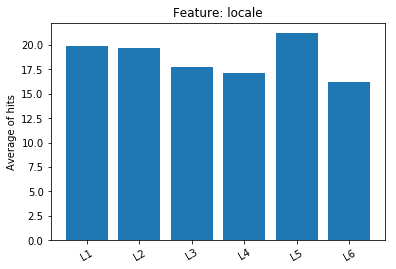

In [7]:
# locale
plot_bar_x(dataset.groupby(['locale'])['hits'].mean(), 'locale')

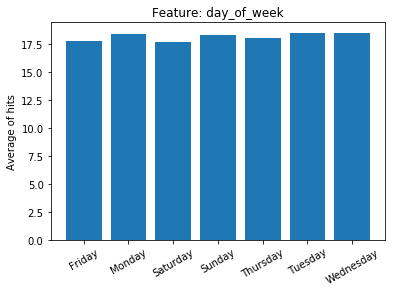

In [8]:
# day_of_week
plot_bar_x(dataset.groupby(['day_of_week'])['hits'].mean(), 'day_of_week')

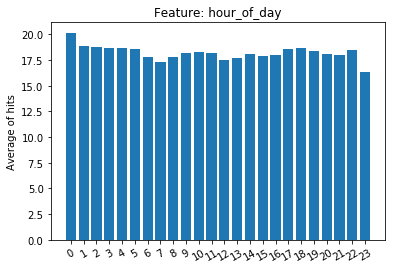

In [9]:
# hour_of_day
plot_bar_x(dataset.groupby(['hour_of_day'])['hits'].mean(), 'hour_of_day')

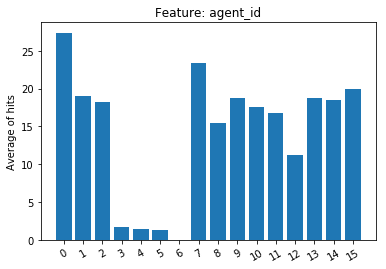

In [10]:
# agent_id
plot_bar_x(dataset.groupby(['agent_id'])['hits'].mean(), 'agent_id')

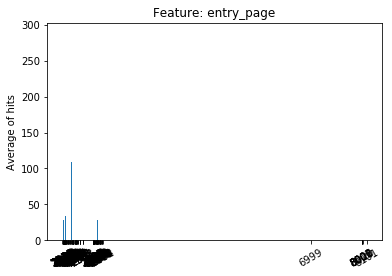

In [11]:
# entry_page
plot_bar_x(dataset.groupby(['entry_page'])['hits'].mean(), 'entry_page')

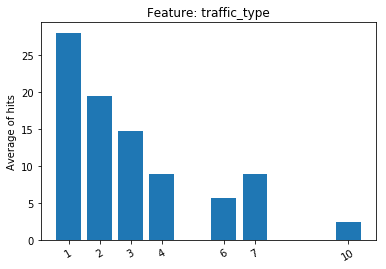

In [12]:
# traffic_type
plot_bar_x(dataset.groupby(['traffic_type'])['hits'].mean(), 'traffic_type')

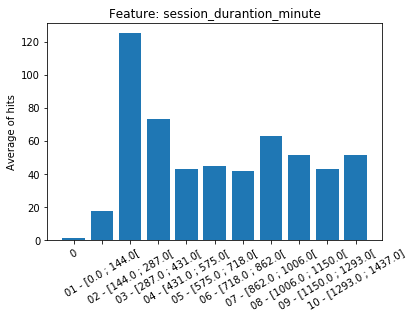

In [13]:
# session_durantion
dataset['session_durantion_minute'] = dataset['session_durantion']/60

session_duration_min = dataset['session_durantion_minute'].min()
session_duration_max = dataset['session_durantion_minute'].max()
interval = (session_duration_max - session_duration_min)/10
session_duration_column = dataset['session_durantion_minute']

conditions = [
    (session_duration_column >= session_duration_min) & (session_duration_column < session_duration_min + interval),
    (session_duration_column >= session_duration_min + interval) & (session_duration_column < session_duration_min + 2*interval),
    (session_duration_column >= session_duration_min + 2*interval) & (session_duration_column < session_duration_min + 3*interval),
    (session_duration_column >= session_duration_min + 3*interval) & (session_duration_column < session_duration_min + 4*interval),
    (session_duration_column >= session_duration_min + 4*interval) & (session_duration_column < session_duration_min + 5*interval),
    (session_duration_column >= session_duration_min + 5*interval) & (session_duration_column < session_duration_min + 6*interval),
    (session_duration_column >= session_duration_min + 6*interval) & (session_duration_column < session_duration_min + 7*interval),
    (session_duration_column >= session_duration_min + 7*interval) & (session_duration_column < session_duration_min + 8*interval),
    (session_duration_column >= session_duration_min + 8*interval) & (session_duration_column < session_duration_min + 9*interval),
    (session_duration_column >= session_duration_min + 9*interval) & (session_duration_column <= session_duration_max)
]

choices = [
    '01 - [' + str(round(session_duration_min + 0*interval)) + ' ; ' + str(round(session_duration_min + 1*interval)) + '[',
    '02 - [' + str(round(session_duration_min + 1*interval)) + ' ; ' + str(round(session_duration_min + 2*interval)) + '[',
    '03 - [' + str(round(session_duration_min + 2*interval)) + ' ; ' + str(round(session_duration_min + 3*interval)) + '[',
    '04 - [' + str(round(session_duration_min + 3*interval)) + ' ; ' + str(round(session_duration_min + 4*interval)) + '[',
    '05 - [' + str(round(session_duration_min + 4*interval)) + ' ; ' + str(round(session_duration_min + 5*interval)) + '[',
    '06 - [' + str(round(session_duration_min + 5*interval)) + ' ; ' + str(round(session_duration_min + 6*interval)) + '[',
    '07 - [' + str(round(session_duration_min + 6*interval)) + ' ; ' + str(round(session_duration_min + 7*interval)) + '[',
    '08 - [' + str(round(session_duration_min + 7*interval)) + ' ; ' + str(round(session_duration_min + 8*interval)) + '[',
    '09 - [' + str(round(session_duration_min + 8*interval)) + ' ; ' + str(round(session_duration_min + 9*interval)) + '[',
    '10 - [' + str(round(session_duration_min + 9*interval)) + ' ; ' + str(round(session_duration_min + 10*interval)) + ']'
]

dataset['session_durantion_minute_band'] = np.select(conditions, choices)

plot_bar_x(dataset.groupby(['session_durantion_minute_band'])['hits'].mean(), 'session_durantion_minute')

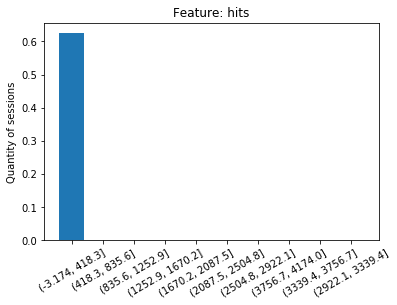

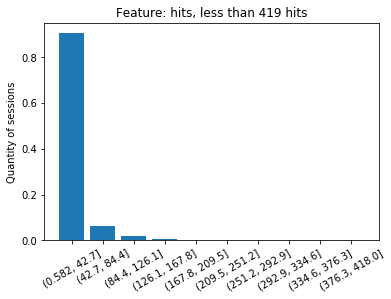

In [14]:
# hits
temp = dataset['hits'].value_counts(normalize = True, bins = 10)
temp.index = temp.index.to_series().astype(str)
plot_bar_x(temp, 'hits', 'Quantity of sessions')

temp = dataset['hits'].loc[dataset['hits'] < 419].value_counts(normalize = True, bins = 10)
temp.index = temp.index.to_series().astype(str)
plot_bar_x(temp, 'hits, less than 419 hits', 'Quantity of sessions')

From the graphs above we can infer about the dataset that:

* category 'L5' from feature 'locale' has an average of hits a little bit higher than the rest of the categories
* category '1' from feature 'traffic_type' has an average of hits higher than the rest of the categories
* there is a discrepancy on the categories of 'agent_id', what indicates that this feature might be good
* only a few categories of 'entry_page' has relevant average of hits
* 'session_durantion_minute' between 0 and 144 minutes has a high average of hits
* most sessions are concentrated on the band of 0 to 42 hits

### Data Preparation

From all features shown above I could think about creating one feature:

* path_length (continuous): count how many paths id were visited from 'path_id_set'

In [15]:
dataset['path_length'] = dataset['path_id_set'].apply(lambda x: len(re.sub('[0-9]', '', str(x))) + 1)

All the scikit-learn models don't accept discrete features in the format of strings and continuous features with NaN, so:

* we have to transform discrete features on binaries (one new column for each category of the feature)
* we have to replace NaN for zero

In [16]:
dataset = pd.concat([
    dataset.reset_index(drop = True),
    pd.get_dummies(dataset['locale'], prefix = 'locale'),
    pd.get_dummies(dataset['day_of_week'], prefix = 'day_of_week'),
    pd.get_dummies(dataset['hour_of_day'], prefix = 'hour_of_day'),
    pd.get_dummies(dataset['agent_id'], prefix = 'agent_id'),
    pd.get_dummies(dataset['traffic_type'], prefix = 'traffic_type')
], axis = 1)

dataset['session_durantion_minute'] = np.nan_to_num(dataset['session_durantion_minute'])

dataset.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,...,agent_id_13,agent_id_14,agent_id_15,traffic_type_1,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_6,traffic_type_7,traffic_type_10
0,988681,L6,Monday,17,1,2111,31672;0,6,7037.0,NaN,...,0,0,0,0,0,0,0,1,0,0
1,988680,L2,Thursday,22,10,2113,31965;0,2,49.0,14.0,...,0,0,0,0,1,0,0,0,0,0
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892.0,14.0,...,0,0,0,1,0,0,0,0,0,0
3,988678,L3,Saturday,19,8,2113,51462,6,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2.0,3.0,...,0,0,0,1,0,0,0,0,0,0


Now that we have analyzed all features distribution from the dataset and created a few others, we can continue handling the data in order to separate the dataset on three datasets, and they are:

* result_dataset (all the observations that were null on the 'hits' feature)
* training_dataset (90% from the remaining observations)
* test_dataset (10% from the remaining observations)

I've used 90/10 for the training and test datasets because I'll use k-fold methodology to evaluate the models performance on the 'validation' dataset.

In [17]:
result_dataset = dataset.loc[dataset['hits'].isnull()]

training_dataset, test_dataset = train_test_split(dataset.loc[~dataset['hits'].isnull()],
                                                  test_size = 0.1,
                                                  random_state = 7)

Below we can see the number of observations for each dataset.

In [40]:
print('Result dataset: ' + str(result_dataset.shape[0]))
print('Training dataset: ' + str(training_dataset.shape[0]))
print('Test dataset: ' + str(test_dataset.shape[0]))

Result dataset: 369446
Training dataset: 557311
Test dataset: 61924


### Modeling

With all datasets required for the modeling process we can start and run all models in a loop and compare their errors.

As our response feature is continuous we will have to use some regression models to predict the response, we'll use:

* linear regression (a very basic model to use as a reference, i.e., low benchmark performance)
* random forest
* support vector machine
* gradient boosting

To evaluate the final model performance we will use the root mean square error (RMSE) as shown below.

<img src = "img/evaluation.png">

To create these models we'll use:

* a sample from the training_dataset (10%) for processing time
* select the continuous features ('session_durantion_minute', 'path_lenght') and the new binary features that we created from the discrete ones ('locale', 'day_of_week', 'hour_of_day', 'agent_id' and 'traffic_type')

In [19]:
allColumns = list(training_dataset.columns.values)

for i in range(0, len(allColumns) -1):
    print(str(i) + ' ' + allColumns[i])

0 row_num
1 locale
2 day_of_week
3 hour_of_day
4 agent_id
5 entry_page
6 path_id_set
7 traffic_type
8 session_durantion
9 hits
10 session_durantion_minute
11 session_durantion_minute_band
12 path_length
13 locale_L1
14 locale_L2
15 locale_L3
16 locale_L4
17 locale_L5
18 locale_L6
19 day_of_week_Friday
20 day_of_week_Monday
21 day_of_week_Saturday
22 day_of_week_Sunday
23 day_of_week_Thursday
24 day_of_week_Tuesday
25 day_of_week_Wednesday
26 hour_of_day_0
27 hour_of_day_1
28 hour_of_day_2
29 hour_of_day_3
30 hour_of_day_4
31 hour_of_day_5
32 hour_of_day_6
33 hour_of_day_7
34 hour_of_day_8
35 hour_of_day_9
36 hour_of_day_10
37 hour_of_day_11
38 hour_of_day_12
39 hour_of_day_13
40 hour_of_day_14
41 hour_of_day_15
42 hour_of_day_16
43 hour_of_day_17
44 hour_of_day_18
45 hour_of_day_19
46 hour_of_day_20
47 hour_of_day_21
48 hour_of_day_22
49 hour_of_day_23
50 agent_id_0
51 agent_id_1
52 agent_id_2
53 agent_id_3
54 agent_id_4
55 agent_id_5
56 agent_id_6
57 agent_id_7
58 agent_id_8
59 agent_

In [20]:
training_dataset.iloc[0:55731, np.r_[9:11, 12:72]].head()

,hits,session_durantion_minute,path_length,locale_L1,locale_L2,locale_L3,locale_L4,locale_L5,locale_L6,day_of_week_Friday,...,agent_id_12,agent_id_13,agent_id_14,agent_id_15,traffic_type_1,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_6,traffic_type_7
218184,8.0,5.300000,2,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0
692185,5.0,0.016667,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
890079,3.0,0.300000,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
338535,29.0,2.916667,3,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
405955,74.0,167.116667,6,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
array = training_dataset.iloc[0:55731, np.r_[9:11, 12:72]].values

X = array[:, 1:62]
Y = array[:, 0]

Linear Regression 2018-09-12 23:07:52.434799
Random Forest 2018-09-12 23:07:55.548537
Support Vector Machine 2018-09-12 23:08:29.895201
Gradient Boosting 2018-09-12 23:49:57.167145
The End - 2018-09-12 23:52:24.934300


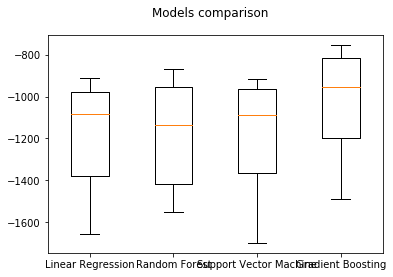

In [116]:
# set seed for reproducibility
seed = 7

# prepare models
models = []
models.append(('Linear Regression', LinearRegression()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('Support Vector Machine', SVR()))
models.append(('Gradient Boosting', GradientBoostingRegressor()))

# evaluate each model
results = []
names = []
scoring = 'neg_mean_squared_error'

for model_name, model in models:
    print(model_name + ' ' + str(datetime.datetime.now()))
    kfold = model_selection.KFold(n_splits = 10,
                                  random_state = seed)    
    cv_results = model_selection.cross_val_score(model, X, Y,
                                                 cv = kfold,
                                                 scoring = scoring)    
    results.append(cv_results)
    names.append(model_name)

print('The End - ' + str(datetime.datetime.now()))

# boxplot models comparison
fig = plt.figure()
fig.suptitle('Models comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Based on the comparison between these four models, the best performance achieved was from the Gradient Boosting algorithm. So, let's apply it and take a look deeper on the model parameters below.

* max_depth
* learning_rate
* n_estimators
* min_samples_leaf

After varying the model parameters and doing a cross-validation k-fold (k equals 10) we end up with the model below.

In [26]:
model = GradientBoostingRegressor(criterion = 'friedman_mse',
                                 max_depth = 3,
                                 learning_rate = 0.05,
                                 n_estimators = 100,
                                 min_samples_leaf = 1,
                                 random_state = 7)

kfold = model_selection.KFold(n_splits = 10,
                              random_state = 7)

cv_results = model_selection.cross_val_score(model, X, Y,
                                             cv = kfold,
                                             scoring = 'neg_mean_squared_error')

print("Neg Mean Squared Error: %.2f " % pd.DataFrame(cv_results).median())

Neg Mean Squared Error: -947.95 


Now that we know the average performance on the cross-validation k-fold we'll fit it on the training_dataset and apply on the test_dataset to see how it performs.

In [29]:
model.fit(X, Y)

array = test_dataset.iloc[:, np.r_[9:11, 12:72]].values

X_test = array[:, 1:62]
Y_test = array[:, 0]

Y_pred = model.predict(X)
Y_test_pred = model.predict(X_test)

print("Mean Squared Error (training): %.2f" % mean_squared_error(Y, Y_pred))
print("Mean Squared Error (test): %.2f" % mean_squared_error(Y_test, Y_test_pred))

Mean Squared Error (training): 930.96
Mean Squared Error (test): 991.88


It seems that the model's performance on the training_dataset and on the test_dataset are very close to each other what indicates that it may probably fit well on the "production" environment, in that manner, on the result_dataset too.

### Evaluation

By last, we will use the model from the last section to predict the hits on the 'result_dataset' and save as a csv file.

In [70]:
array = result_dataset.iloc[:, np.r_[9:11, 12:73]].values

X_result = array[:, 1:62]
Y_result = model.predict(X_result)

result = pd.concat([pd.DataFrame(result_dataset['row_num']).reset_index(drop = True),
                    pd.DataFrame(Y_result).reset_index(drop = True)],
                   axis = 1)

result.columns = ['row_num', 'hits']

result.head()

,row_num,hits
0,988681,57.761966
1,988666,64.256978
2,988665,3.723602
3,988664,98.668566
4,988663,17.514411


In [73]:
print(result.shape[0])

369446


In [74]:
result.to_csv(path_or_buf = '../database/result.csv', sep = ';', index = False)